In [1]:
import logging
import time
import os
import pickle

#from DataPrep import data_prep

import numpy as np
import matplotlib.pyplot as plt

#import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
#import tensorflow_text  # pylint: disable=unused-import
import pandas as pd
import numpy as np
import re
import seaborn as sns

from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model,  Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dropout, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, Concatenate
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Attention
from tensorflow.keras.optimizers import Adam, Adagrad
from keras.losses import sparse_categorical_crossentropy
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings
import random

In [2]:
cd ..

/Users/harini/MIT Dropbox/Harini Narayanan/Harini Narayanan’s files/1_Home/CodonOptimization/CO_Application/h_tPA_IL12


In [3]:
Seq_Data = pd.read_excel('h_tPA_IL12.xlsx')
AA_ts_seq_v0 = (Seq_Data.iloc[:,2] + Seq_Data.iloc[:,1]).tolist()
AA_ts_seq = []
for seq in AA_ts_seq_v0:
    AA_ts_seq.append(seq+'*')

In [4]:
Seq_Data 

,Name,CDS,SP
0,tPA,SQEIHARFRRGARSYQVICRDEKTQMIYQQHQSWLRPVLRSNRVEY...,MDAMKRGLCCVLLLCGAVFVSP
1,IL12p40 (IL12B),IWELKKDVYVVELDWYPDAPGEMVVLTCDTPEEDGITWTLDQSSEV...,MCHQQLVISWFSLVFLASPLVA
2,IL12p35 (IL12A),RNLPVATPDPGMFPCLHHSQNLLRAVSNMLQKARQTLEFYPCTSEE...,MCPARSLLLVATLVLLDHLSLA


In [5]:
def tokenize_AA(sequences):
    AA_dict = {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
               'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19,
               'Y': 20, 'X': 21, 'Z': 21, 'B': 21, 'U': 21, 'O': 21, '*': 22}

    seq_tokenized = []
    for s in range(len(sequences)):
        seq = sequences[s]
        temp = [24]  # Start token
        for i in range(len(seq)):
            temp.append(AA_dict[seq[i]])
        temp.append(23)

        seq_tokenized.append(temp)

    return seq_tokenized, AA_dict

In [6]:
def AA_Codon_list():
    dic_AA_codon = {'A': ['GCT', 'GCC', 'GCA', 'GCG'],
                    'C': ['TGT', 'TGC'],
                    'D': ['GAT', 'GAC'],
                    'E': ['GAA', 'GAG'],
                    'F': ['TTT', 'TTC'],
                    'G': ['GGT', 'GGA', 'GGC', 'GGG'],
                    'H': ['CAT', 'CAC'],
                    'I': ['ATT', 'ATC', 'ATA'],
                    'K': ['AAA', 'AAG'],
                    'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
                    'M': ['ATG'],
                    'N': ['AAT', 'AAC'],
                    'P': ['CCT', 'CCC', 'CCA', 'CCG'],
                    'Q': ['CAA', 'CAG'],
                    'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
                    'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
                    'T': ['ACT', 'ACC', 'ACA', 'ACG'],
                    'V': ['GTT', 'GTC', 'GTA', 'GTG'],
                    'W': ['TGG'],
                    'Y': ['TAT', 'TAC'],
                    '*': ['TAA', 'TAG', 'TGA']}

    codon_list = []
    AA_list = []
    for key in dic_AA_codon:
        for i in range(len(dic_AA_codon[key])):
            AA_list.append(key)
        for i in dic_AA_codon[key]:
            codon_list.append(i)
    return AA_list, codon_list

def tokenize_Codon(sequences):
    AA_list, codon_list = AA_Codon_list()
    keys = codon_list
    values = range(1, len(codon_list) + 1)
    Codon_dict = dict(zip(keys, values))
    seq_tokenized = []
    for s in range(len(sequences)):
        seq = sequences[s]
        temp = [65]  # Start token
        for i in range(int(len(seq) / 3)):
            temp.append(Codon_dict[seq[3 * i: 3 * (i + 1)]])
        
        temp.append(66)
        seq_tokenized.append(temp)

    return seq_tokenized, Codon_dict

def tokenize_AA(sequences):
    AA_dict = {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
               'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19,
               'Y': 20, 'X': 21, 'Z': 21, 'B': 21, 'U': 21, 'O': 21, '*': 22}

    seq_tokenized = []
    for s in range(len(sequences)):
        seq = sequences[s]
        temp = [24]  # Start token
        for i in range(len(seq)):
            temp.append(AA_dict[seq[i]])
        temp.append(23)

        seq_tokenized.append(temp)

    return seq_tokenized, AA_dict


def tokenized_AACodonList():
    AA_dict = {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
               'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19,
               'Y': 20, 'X': 21, 'Z': 21, 'B': 21, 'U': 21, 'O': 21, '*': 22}
    dic_AA_codon = {'A': ['GCT', 'GCC', 'GCA', 'GCG'],
                    'C': ['TGT', 'TGC'],
                    'D': ['GAT', 'GAC'],
                    'E': ['GAA', 'GAG'],
                    'F': ['TTT', 'TTC'],
                    'G': ['GGT', 'GGA', 'GGC', 'GGG'],
                    'H': ['CAT', 'CAC'],
                    'I': ['ATT', 'ATC', 'ATA'],
                    'K': ['AAA', 'AAG'],
                    'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
                    'M': ['ATG'],
                    'N': ['AAT', 'AAC'],
                    'P': ['CCT', 'CCC', 'CCA', 'CCG'],
                    'Q': ['CAA', 'CAG'],
                    'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
                    'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
                    'T': ['ACT', 'ACC', 'ACA', 'ACG'],
                    'V': ['GTT', 'GTC', 'GTA', 'GTG'],
                    'W': ['TGG'],
                    'Y': ['TAT', 'TAC'],
                    '*': ['TAA', 'TAG', 'TGA']}
    AA_list, codon_list = AA_Codon_list()
    token_AA_codon = {}
    for i in dic_AA_codon.keys():
        token_AA_codon[AA_dict[i]] = []
        for j in dic_AA_codon[i]:
            token_AA_codon[AA_dict[i]].append(codon_list.index(j)+1)
            
    return token_AA_codon

In [7]:
AA_list, codon_list = AA_Codon_list()
token_AA_codon = tokenized_AACodonList()
token_AA_codon[23] = [66]
AA_seq_tokenized, AA_seq_tokenizer = tokenize_AA(AA_ts_seq)
AA_pad_seq = pad_sequences(AA_seq_tokenized, maxlen=1001, dtype='int32', padding="post", truncating="post")

AA_ts = AA_pad_seq

### Load the model

In [8]:
cd ..

/Users/harini/MIT Dropbox/Harini Narayanan/Harini Narayanan’s files/1_Home/CodonOptimization/CO_Application


In [9]:
#cd ..

In [10]:
Settings = pd.read_csv('../Models/2Target_Pichia/BO_forHyperParameter/Arch1/Round3.csv').iloc[:, 1:]
Setting_no =1

Max_length = 1000
learning_rate = 0.001
batch_size = 150
epochs = 100
aa_vocab_size = 25
dna_vocab_size = 67


hidden_size_enc = int(Settings['Enc hidden size'][Setting_no])
hidden_size_enc_aa = int(Settings['Enc hidden size'][Setting_no])
embedding_size_enc = int(Settings['Enc Embedding size'][Setting_no])
embedding_size_dec = int(Settings['Dec Embedding size'][Setting_no])
Dense_layer_size = int(Settings['Dense Layer size'][Setting_no])
Dense_layer_size_aa = int(Settings['Dense Layer size aa'][Setting_no])

drop_rate = Settings['Drop rate'][Setting_no]
drop_rate_aa = Settings['Drop rate aa'][Setting_no]

    
input_sequence = Input(shape=(Max_length,))
encod_emb = Embedding(input_dim= aa_vocab_size, output_dim = embedding_size_enc,trainable=True, mask_zero = True)
embedding = encod_emb(input_sequence)

encoder = Bidirectional(GRU(hidden_size_enc, return_sequences=True, return_state = True),
                        merge_mode="concat", weights=None)

encoder_sequence, encoder_final_f, encoder_final_b  = encoder(embedding)

encoder_final = Concatenate(axis=-1)([encoder_final_f, encoder_final_b])



decoder_inputs = Input(shape=(Max_length -1, ))
decoder_inputs_aa = Input(shape=(Max_length, ))

dex=  Embedding(input_dim = dna_vocab_size, output_dim = embedding_size_dec, trainable=True, mask_zero = True)


final_dex= dex(decoder_inputs)
final_dex_aa =  encod_emb(decoder_inputs_aa)


decoder = GRU(2*hidden_size_enc, return_sequences = True, return_state = True)
decoder_aa =  GRU(2*hidden_size_enc_aa, return_sequences = True, return_state = True)

decoder_sequence, decoder_final = decoder(final_dex, initial_state=encoder_final)
decoder_sequence_aa, decoder_final_aa = decoder_aa(final_dex_aa, initial_state=encoder_final)


attn_layer = Attention()
attn_out = attn_layer([decoder_sequence, encoder_sequence])
attn_layer_aa = Attention()
attn_out_aa = attn_layer_aa([decoder_sequence_aa, encoder_sequence])

decoder_concat_input = Concatenate(axis=-1)([decoder_sequence, attn_out]) #decoder_sequence, 
decoder_concat_input_aa = Concatenate(axis=-1)([decoder_sequence_aa, attn_out_aa]) #decoder_sequence,


Intermediate_layer = TimeDistributed(Dense(Dense_layer_size, activation='tanh'))
Intermediate_layer_aa= TimeDistributed(Dense(Dense_layer_size_aa, activation='tanh'))

Intemediate_output = Intermediate_layer(decoder_concat_input) #decoder_concat_input
Intemediate_output_aa = Intermediate_layer_aa(decoder_concat_input_aa) #decoder_concat_input


dropout_layer = Dropout(drop_rate)
dropout_output = dropout_layer(Intemediate_output)

dropout_layer_aa = Dropout(drop_rate_aa)
dropout_output_aa = dropout_layer(Intemediate_output_aa)

dense_layer = TimeDistributed(Dense(dna_vocab_size, activation='softmax'))
logits = dense_layer(dropout_output)

dense_layer_aa = TimeDistributed(Dense(aa_vocab_size, activation='softmax'))
logits_aa = dense_layer_aa(dropout_output_aa)

enc_dec_model = Model([input_sequence, decoder_inputs, decoder_inputs_aa], [logits, logits_aa])

enc_dec_model.compile(loss=sparse_categorical_crossentropy,
              optimizer=Adam(learning_rate = learning_rate),
              metrics=['accuracy'])
enc_dec_model.summary()

enc_dec_model.load_weights("../Models/OptimizedModel_Checkpoints/PichiaData/2Target_AllData/FinArch1_AttnCorr_cp.ckpt")

after = encod_emb.get_weights()[0]

encoder_model = Model(input_sequence, [encoder_final, encoder_sequence])
encoder_model.summary()


decoder_model_aa = Model([decoder_inputs_aa, encoder_final, encoder_sequence], [logits_aa])

decoder_model_aa.summary()

encoder_sequence = Input(shape = (Max_length, 2*hidden_size_enc))


decoder_states_inputs = Input(shape = (2*hidden_size_enc,))
decoder_inputs_inf = Input(shape = (1,)) 
final_dex2= dex(decoder_inputs_inf)

decoder_outputs2, decoder_states2 = decoder(final_dex2, initial_state=decoder_states_inputs)

attn_out_inf = attn_layer([decoder_outputs2, encoder_sequence])

decoder_concat_input_inf = Concatenate(axis=-1)([decoder_outputs2, attn_out_inf])

decoder_out_fin = dense_layer(dropout_layer(Intermediate_layer(decoder_concat_input_inf)))

decoder_model = Model(
    [decoder_inputs_inf, decoder_states_inputs, encoder_sequence],
    [decoder_out_fin, decoder_states2])

decoder_model.summary()

2025-04-20 19:55:05.746547: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1000, 42)     1050        ['input_1[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 999)]        0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 1000, 1020)  1695240     ['embedding[0][0]']          

 gru_2 (GRU)                    [(None, 1000, 1020)  3255840     ['embedding[2][0]',              
                                , (None, 1020)]                   'input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 1000, 1020)  0           []                               
                                ]                                                                 
                                                                                                  
 attention_1 (Attention)        (None, 1000, 1020)   0           ['gru_2[1][0]',                  
                                                                  'input_5[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 1000, 2040)   0           ['gru_2[1][0]',                  
          

In [11]:
def decode_cds_sequence(input_seq):
    #encode the input as state vectors
    batch_size = 1
    dna_vocab = 67
    
    final_value, sequence_enc = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    #populate the first character of target sequence with the start character
    target_seq[0, 0] = 65

    states_value = final_value
    stop_condition = False
    decoded_sentence = [65] #''
    counter = 0
    loop_check = 0
    
    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq, states_value, sequence_enc])
        Mask = np.zeros((1, dna_vocab))
        Mask[0, token_AA_codon[input_seq.tolist()[0][counter]]] = 1
        output_tokens_modified = np.multiply(output_tokens, Mask)
        
        sampled_token_index = np.argmax(output_tokens_modified )
        decoded_sentence.append(sampled_token_index)
        counter = counter + 1
        appended_index = sampled_token_index
  
        if (len(decoded_sentence) >= Max_length or appended_index == 66):
            stop_condition = True
        
        target_seq[0, 0] = sampled_token_index
        #update states
        states_value = h
        
    
        
    print(counter)
    return decoded_sentence

def decode_aa_sequence(input_seq):
    
    final_value, sequence_enc = encoder_model.predict(input_seq)
    output_tokens = decoder_model_aa.predict([input_seq ,final_value, sequence_enc])
    
    decoded_sentence = []
    for i in range(len(input_seq[0])):
        sampled_token_index = np.argmax(output_tokens[0,i,:])
        decoded_sentence.append(sampled_token_index)
        if sampled_token_index ==23:
            break
    
    return decoded_sentence

#### CDS prediction

In [12]:
cd h_tPA_IL12

/Users/harini/MIT Dropbox/Harini Narayanan/Harini Narayanan’s files/1_Home/CodonOptimization/CO_Application/h_tPA_IL12


In [13]:
encoder_input_data = AA_ts
cds_ts_predicted = []
offset = 0

for seq_index in np.arange(offset+0,len(AA_ts)):#len(AA_ts)  2500,len(AA_ts), offset+500
    #take one sequence (part of the training set) for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1, 1:Max_length+1]
    decoded_sentence = decode_cds_sequence(input_seq)
    cds_ts_predicted.append(decoded_sentence)
    


pd.DataFrame(cds_ts_predicted).to_excel("./PredictedSequences/PichiaArch1_h_tPA_IL12.xlsx")

2025-04-20 19:55:13.904401: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


564
330
221


In [14]:
len(cds_ts_predicted[0])

565

In [15]:
encoder_input_data = AA_ts
aa_ts_predicted = []

for seq_index in np.arange(0, len(AA_ts)):#len(AA_ts)  2500,len(AA_ts)
    decoded_sentence_aa = decode_aa_sequence(encoder_input_data[seq_index: seq_index + 1,0:Max_length])
    aa_ts_predicted.append(decoded_sentence_aa)
    

from sklearn.metrics import accuracy_score
acc = []
acc_aa = []
for i in np.arange(0, len(AA_ts)): #len(AA_ts) - 2500
   
    obs_aa = [x for x in AA_ts[i, 1:Max_length+1] if x]
    
    if len(obs_aa) == len(aa_ts_predicted[i]):
        acc_aa.append(accuracy_score(obs_aa, aa_ts_predicted[i]))
        #print(accuracy_score(obs, cds_ts_predicted[i]))
    else:
        acc_aa.append(np.nan)
        #print(NaN)

#pd.DataFrame(acc_aa).to_excel('AA_Check.xlsx','PichiaArch1')

2025-04-20 19:55:56.449706: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


<AxesSubplot:ylabel='Count'>

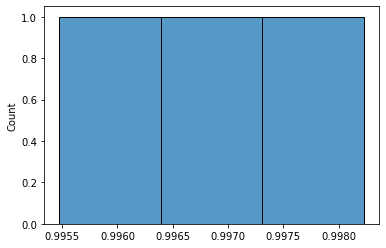

In [16]:
sns.histplot(acc_aa)

In [ ]:
acc_aa